## Reading the data

In [562]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_data_original = pd.read_csv("basket_data_by_date_train_big.csv")
test_data_original = pd.read_csv("basket_data_by_date_test_big.csv")

See if we successfully loaded the dataset:

In [564]:
train_data_original.info()
test_data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      200000 non-null  int64  
 1   Itemname    200000 non-null  object 
 2   Quantity    200000 non-null  int64  
 3   Date        200000 non-null  object 
 4   Price       200000 non-null  float64
 5   CustomerID  200000 non-null  int64  
 6   cost        200000 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 10.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65326 entries, 0 to 65325
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      65326 non-null  int64  
 1   Itemname    65326 non-null  object 
 2   Quantity    65326 non-null  int64  
 3   Date        65326 non-null  object 
 4   Price       65326 non-null  float64
 5   CustomerID  65326 non-null  int64  
 6   cost    

The result shown above indicates the datasets are successfully loaded. Next step is to process the dataset.

## visualisation

In order to see the distribution of quantity for each item, I visualised two datasets as follows:

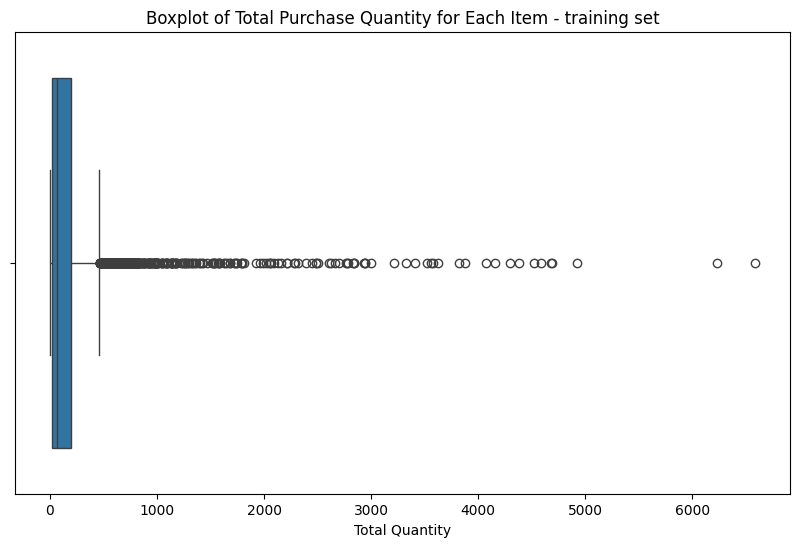

In [540]:
item_total_quantity = train_data_original.groupby('Itemname')['Quantity'].sum()

plt.figure(figsize=(10, 6))
sns.boxplot(x=item_total_quantity.values)
plt.xlabel('Total Quantity')
plt.title('Boxplot of Total Purchase Quantity for Each Item - training set')
plt.show()

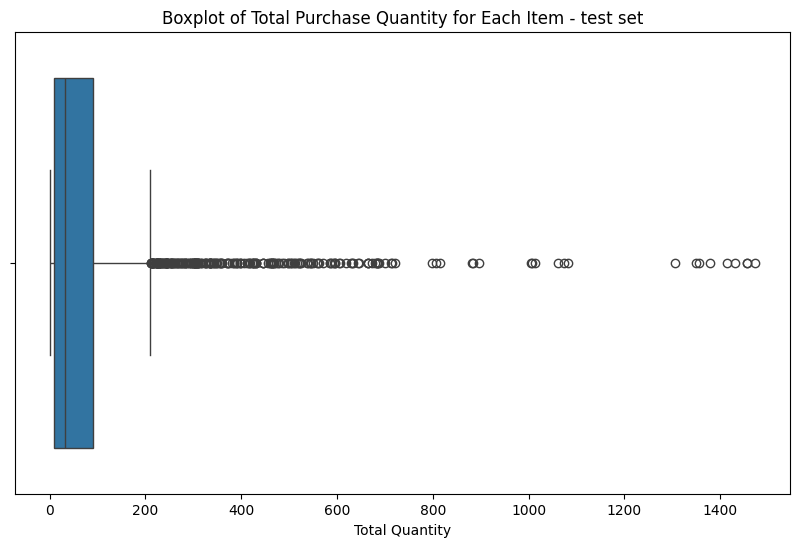

In [541]:
item_total_quantity = test_data_original.groupby('Itemname')['Quantity'].sum()

plt.figure(figsize=(10, 6))
sns.boxplot(x=item_total_quantity.values)
plt.xlabel('Total Quantity')
plt.title('Boxplot of Total Purchase Quantity for Each Item - test set')
plt.show()

This step is in preparation for future noise removal.

## pre process dataset

After reading the datasets, we need to further analyse the data. I need to observe whether the variables I need appear unreasonable, which is to check if the quantity appears to be less than 0.

In [565]:
negative_quantity = train_data_original[train_data_original['Quantity'] < 0]
print("The number of negative quantity in train data is: ", negative_quantity)

The number of negative quantity in train data is:  Empty DataFrame
Columns: [BillNo, Itemname, Quantity, Date, Price, CustomerID, cost]
Index: []


In [566]:
negative_quantity_test = test_data_original[test_data_original['Quantity'] < 0]
print("The number of negative quantity in train data is: ", negative_quantity)

The number of negative quantity in train data is:  Empty DataFrame
Columns: [BillNo, Itemname, Quantity, Date, Price, CustomerID, cost]
Index: []


Also, we need to check if there is any missing data in two datasets. If so, we need to remove them.

In [563]:
# check if there is any missing values
print("Train Data Missing Values:")
print(train_data_original.isnull().sum())

# check if there are missing values in the test set
print("\nTest Data Missing Values:")
print(test_data_original.isnull().sum())

Train Data Missing Values:
BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

Test Data Missing Values:
BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64


As we can see, there is no missing value, so we dont need to deal with them. 

BillNo, Date, price and Cost are not necessary for this collaborative filtering system also. So I removed these columns. 

In [543]:
# delete unrelated columns
train_data = train_data_original.drop(columns=['BillNo', 'Date', 'Price', 'cost'])
test_data = test_data_original.drop(columns=['BillNo', 'Date', 'Price', 'cost'])

In [544]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Itemname    200000 non-null  object
 1   Quantity    200000 non-null  int64 
 2   CustomerID  200000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65326 entries, 0 to 65325
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Itemname    65326 non-null  object
 1   Quantity    65326 non-null  int64 
 2   CustomerID  65326 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


To clear the noise, I'm going to pick the more popular items

In [545]:
# calculate the total purchase quantity for each item
item_total_purchase = train_data.groupby('Itemname')['Quantity'].sum()

popular_items = item_total_purchase[item_total_purchase > 700]

train_data = train_data[train_data['Itemname'].isin(popular_items.index)]

In [547]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73604 entries, 2 to 199997
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Itemname    73604 non-null  object
 1   Quantity    73604 non-null  int64 
 2   CustomerID  73604 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65326 entries, 0 to 65325
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Itemname    65326 non-null  object
 1   Quantity    65326 non-null  int64 
 2   CustomerID  65326 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


## create user-item matrix

In [548]:
# identify the users unique to the test set
unique_users = train_data['CustomerID'].unique()
unique_items = train_data['Itemname'].unique()

user_item_matrix = pd.DataFrame(index=unique_users, columns=unique_items)

# iterate over the rows in the train set and fill in the user-item matrix
for index, row in train_data.iterrows():
    user_id = row['CustomerID']
    item_id = row['Itemname']
    rating = row['Quantity']
    user_item_matrix.loc[user_id, item_id] = rating

# fill in the missing values with 0
user_item_matrix.fillna(0, inplace=True)

# check the user-item matrix
user_item_matrix.iloc[:10, :20]

/var/folders/n3/ddr1nygd4b11p0zv8kwtqx3w0000gn/T/ipykernel_68959/667173066.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  user_item_matrix.fillna(0, inplace=True)


,WHITE HANGING HEART T-LIGHT HOLDER,CREAM CUPID HEARTS COAT HANGER,WHITE METAL LANTERN,HOME BUILDING BLOCK WORD,LOVE BUILDING BLOCK WORD,POPPY'S PLAYHOUSE BEDROOM,POPPY'S PLAYHOUSE KITCHEN,JAM MAKING SET WITH JARS,FELTCRAFT PRINCESS CHARLOTTE DOLL,DOORMAT NEW ENGLAND,WOOD 2 DRAWER CABINET WHITE FINISH,WOODEN FRAME ANTIQUE WHITE,WOODEN PICTURE FRAME WHITE FINISH,WOOD S/3 CABINET ANT WHITE FINISH,JUMBO BAG PINK VINTAGE PAISLEY,JUMBO STORAGE BAG SUKI,JUMBO BAG PINK POLKADOT,STRAWBERRY LUNCH BOX WITH CUTLERY,STRAWBERRY CHARLOTTE BAG,LUNCH BAG RED RETROSPOT
17850,6,8,6,0,0,0,0,0,0,0,4,6,6,4,0,0,0,0,0,0
13047,0,0,0,3,3,6,6,6,4,4,0,0,0,0,0,0,0,0,0,0
14688,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,1,10,10
15311,0,1,0,2,2,0,0,0,0,10,1,0,1,1,5,3,4,1,1,1
16098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18074,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17420,0,0,0,0,0,0,0,6,0,0,0,0,0,0,10,0,0,0,0,0
16250,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12431,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,10
13705,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [549]:
user_item_matrix_array = user_item_matrix.values
user_item_matrix_array

array([[6, 8, 6, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [550]:
user_item_matrix_customers = user_item_matrix.index
user_item_matrix_customers

Index([17850, 13047, 14688, 15311, 16098, 18074, 17420, 16250, 12431, 13705,
       ...
       12398, 15345, 16708, 17193, 15963, 18045, 14173, 13028, 13978, 16056],
      dtype='int64', length=3388)

## Make recommendation

Implementation algorithm reference: the movie recommender system solution in week 10.

In [551]:
def similarity(user1, user2):
    # Calculate the dot product of the two user vectors
    dot_product = np.dot(user1, user2)
    # Calculate the magnitude of the two user vectors
    magnitude = np.sqrt(np.sum(user1 ** 2) * np.sum(user2 ** 2))
    # Calculate the similarity between the two users
    similarity = dot_product/magnitude
    return similarity

In [552]:
def predict_rating(user_ratings, item_ratings):
    # find the indices of the items that have been bought
    rated_indices = np.where(item_ratings != 0)[0]

    # get the quantity of the items that have been bought
    ratings = item_ratings[rated_indices]

    rated_users = user_ratings[rated_indices]

    # calculate similarities
    similarities = [similarity(user_ratings[0], rated_users[i]) for i in range(len(rated_indices))]
    
    # using similarities to calculate the weighted sum
    weighted_sum = np.dot(similarities, ratings)
    weighted_sum /= np.sum(similarities)
    return weighted_sum

In [553]:
def recommend_items(user_ratings, target_user):
    num_users, num_movies = user_ratings.shape

    # find the unboughted items
    unwatched_indices = np.where(user_ratings[target_user] == 0)[0]

    # predict the ratings for the unboughted items
    predicted_ratings = [predict_rating(user_ratings, user_ratings[:, movie_index]) for movie_index in unwatched_indices]

    # ranking
    sorted_indices = np.argsort(predicted_ratings)[::-1]

    top_items = sorted_indices[:15]
    # recommended_movies = [f"Items {i+1}" for i in top_items]

    recommended_movies = [user_item_matrix.columns[i] for i in top_items]
    
    return recommended_movies

## evaluation

This step is to use test set to evaluate my recommender system above.

In [554]:
item_total_purchase = test_data.groupby('Itemname')['Quantity'].sum()

popular_items = item_total_purchase[item_total_purchase > 700]

test_data = test_data[test_data['Itemname'].isin(popular_items.index)]

In [555]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4992 entries, 4 to 65321
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Itemname    4992 non-null   object
 1   Quantity    4992 non-null   int64 
 2   CustomerID  4992 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 156.0+ KB


In [556]:
# identify the users unique to the test set
unique_users = test_data['CustomerID'].unique()
unique_items = test_data['Itemname'].unique()

user_item_matrix = pd.DataFrame(index=unique_users, columns=unique_items)

# iterate over the rows in the train set and fill in the user-item matrix
for index, row in test_data.iterrows():
    user_id = row['CustomerID']
    item_id = row['Itemname']
    rating = row['Quantity']
    user_item_matrix.loc[user_id, item_id] = rating

# fill in the missing values with 0
user_item_matrix.fillna(0, inplace=True)

# check the user-item matrix
user_item_matrix.iloc[:10, :20]

/var/folders/n3/ddr1nygd4b11p0zv8kwtqx3w0000gn/T/ipykernel_68959/1734941171.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  user_item_matrix.fillna(0, inplace=True)


,PAPER CHAIN KIT 50'S CHRISTMAS,JUMBO BAG 50'S CHRISTMAS,HOT WATER BOTTLE KEEP CALM,JUMBO BAG VINTAGE CHRISTMAS,JUMBO BAG RED RETROSPOT,JUMBO BAG VINTAGE LEAF,JUMBO SHOPPER VINTAGE RED PAISLEY,LUNCH BAG RED RETROSPOT,LUNCH BAG VINTAGE DOILY,WHITE HANGING HEART T-LIGHT HOLDER,LUNCH BAG SPACEBOY DESIGN,VINTAGE DOILY TRAVEL SEWING KIT,LUNCH BAG SUKI DESIGN,BAKING SET 9 PIECE RETROSPOT,VINTAGE CHRISTMAS BUNTING,VINTAGE DOILY JUMBO BAG RED,ASSORTED COLOUR BIRD ORNAMENT,RABBIT NIGHT LIGHT,JUMBO BAG PAISLEY PARK,LUNCH BAG PAISLEY PARK
14341,6,10,4,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14482,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,1,0,1
13263,0,0,2,0,0,0,0,1,5,1,1,2,1,0,0,0,0,0,0,0
13601,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
16225,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0
15240,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16173,0,0,0,0,10,0,10,0,10,0,0,0,0,3,0,0,0,0,0,0
17511,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0
16071,0,0,0,10,10,0,0,0,0,6,0,0,0,3,0,0,0,0,0,0
12748,3,2,1,1,1,1,4,3,2,1,3,2,1,1,2,1,5,3,1,1


In [557]:
user_item_matrix_array = user_item_matrix.values
user_item_matrix_array

array([[ 6, 10,  4, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  4],
       [ 0,  0,  2, ...,  0,  0,  0],
       ...,
       [ 0,  0,  8, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [558]:
user_item_matrix_customers = user_item_matrix.index
user_item_matrix_customers

Index([14341, 14482, 13263, 13601, 16225, 15240, 16173, 17511, 16071, 12748,
       ...
       13510, 16833, 16358, 15898, 17144, 14441, 12423, 14422, 12526, 12680],
      dtype='int64', length=1196)

In [560]:
total_precision = 0
total_recall = 0
total_users = 0

# iriterate over the users in the test set
for user in range(user_item_matrix_array.shape[0]):
    recommended_items = recommend_items(user_item_matrix_array, user)
    be_recommended_user = user_item_matrix_customers[user]
    actual_items = test_data[test_data['CustomerID'] == be_recommended_user]['Itemname'].unique()

    # calculate the true positive and false positive
    tp = len(set(recommended_items) & set(actual_items))
    fp = len(recommended_items) - tp

    if len(actual_items) == 0:
        continue

    # calculate the recall
    fn = len(actual_items) - tp
    recall = tp / (tp + fn)

    # calculate the precision
    if (tp + fp) > 0:
        precision = tp / (tp + fp)
        total_precision += precision
        total_recall += recall
        total_users += 1

    print("User ID:", be_recommended_user)
    print("Recommended items:", recommended_items)
    print("Actual items:", actual_items)
    print()

average_precision = total_precision / total_users if total_users > 0 else 0
average_recall = total_recall / total_users if total_users > 0 else 0

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

User ID: 14341
Recommended items: ['VINTAGE CHRISTMAS BUNTING', 'WHITE HANGING HEART T-LIGHT HOLDER', 'RABBIT NIGHT LIGHT', 'LUNCH BAG SPACEBOY DESIGN', "JUMBO BAG 50'S CHRISTMAS", 'LUNCH BAG SUKI DESIGN', "PAPER CHAIN KIT 50'S CHRISTMAS", 'BAKING SET 9 PIECE RETROSPOT', 'HOT WATER BOTTLE KEEP CALM', 'JUMBO BAG VINTAGE LEAF', 'ASSORTED COLOUR BIRD ORNAMENT', 'JUMBO SHOPPER VINTAGE RED PAISLEY', 'JUMBO BAG RED RETROSPOT', 'VINTAGE DOILY TRAVEL SEWING KIT', 'LUNCH BAG VINTAGE DOILY']
Actual items: ["PAPER CHAIN KIT 50'S CHRISTMAS" "JUMBO BAG 50'S CHRISTMAS"
 'HOT WATER BOTTLE KEEP CALM' 'JUMBO BAG VINTAGE CHRISTMAS'
 'JUMBO BAG RED RETROSPOT' 'JUMBO BAG VINTAGE LEAF']

User ID: 14482
Recommended items: ['RABBIT NIGHT LIGHT', 'JUMBO BAG RED RETROSPOT', 'VINTAGE CHRISTMAS BUNTING', 'VINTAGE DOILY JUMBO BAG RED', 'JUMBO BAG VINTAGE CHRISTMAS', "JUMBO BAG 50'S CHRISTMAS", 'JUMBO SHOPPER VINTAGE RED PAISLEY', 'JUMBO BAG VINTAGE LEAF', 'ASSORTED COLOUR BIRD ORNAMENT', 'LUNCH BAG RED RETROSPOT'

Visualisation of the evaluation metrics

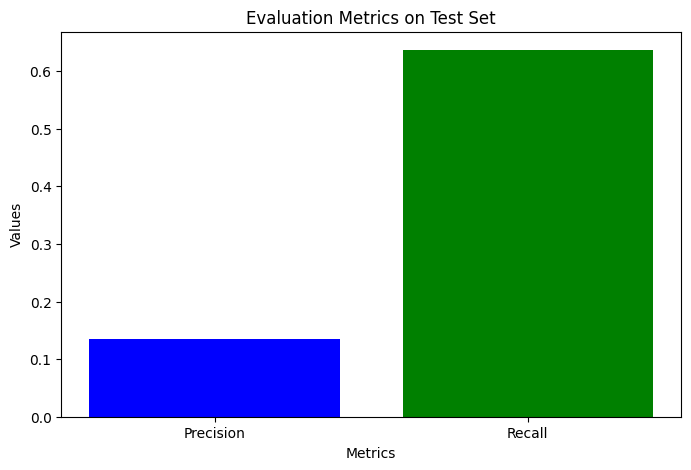

In [561]:
metrics = ['Precision', 'Recall']
values = [average_precision, average_recall]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green'])
plt.title('Evaluation Metrics on Test Set')
plt.xlabel('Metrics')
plt.ylabel('Values')

plt.show()

## References

[1] Hussien, FTA, Rahma, AMS & Abdulwahab, HB 2021, ‘An e‐commerce recommendation system based on dynamic analysis of customer behavior’, *Sustainability (Basel, Switzerland)*, vol. 13, no. 19, pp. 1-21.

[2] Jia, Z, Yang, Y, Gao, W & Chen, X 2015, ‘User-Based Collaborative Filtering for Tourist Attraction Recommendations’, in The Institute of Electrical and Electronics Engineers, Inc. (IEEE) Conference Proceedings, *The Institute of Electrical and Electronics Engineers, Inc. (IEEE)*, Piscataway, pp. 22-25

[3] Li, W, Cai, Y, Hanafiah, MH & Liao, Z 2024, ‘An Empirical Study on Personalized Product Recommendation Based on Cross-Border E-Commerce Customer Data Analysis’,*Journal of Organizational and End User Computing*, vol. 36, no. 1, pp. 1–16.

[4] Silveira, T, Zhang, M, Lin, X, Liu, Y & Ma, S 2019, ‘How good your recommender system is? A survey on evaluations in recommendation’, *International Journal of Machine Learning and Cybernetics*, vol. 10, no. 5, pp. 813–831.

[5] Xu, Q & Wang, J 2022, ‘A Social-aware and Mobile Computing-based E-Commerce Product Recommendation System’, *Computational Intelligence and Neuroscience*, vol. 2022, pp. 1-8. 


